**전처리**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [6]:
sub_df=pd.read_csv('sample_submission.csv')
test_df=pd.read_csv('test.csv')
train_df=pd.read_csv('train.csv')

In [7]:
#결측값 확인
print(train_df.isnull().sum())

index                   0
quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64


- 시각화를 통해 어떤 변수를 범주할지 확인하기.

## 기준
- 특정 품질(quality) 수준에서 값의 중앙값/분포가 뚜렷하게 차이날 경우 → 범주화 고려
- 모든 품질 수준에서 값이 고르게 분포 → 범주화에 적합하지 않음.
- 아웃라이어가 많고 변동성이 클 경우 → 범주화가 더 안정적일 수 있음

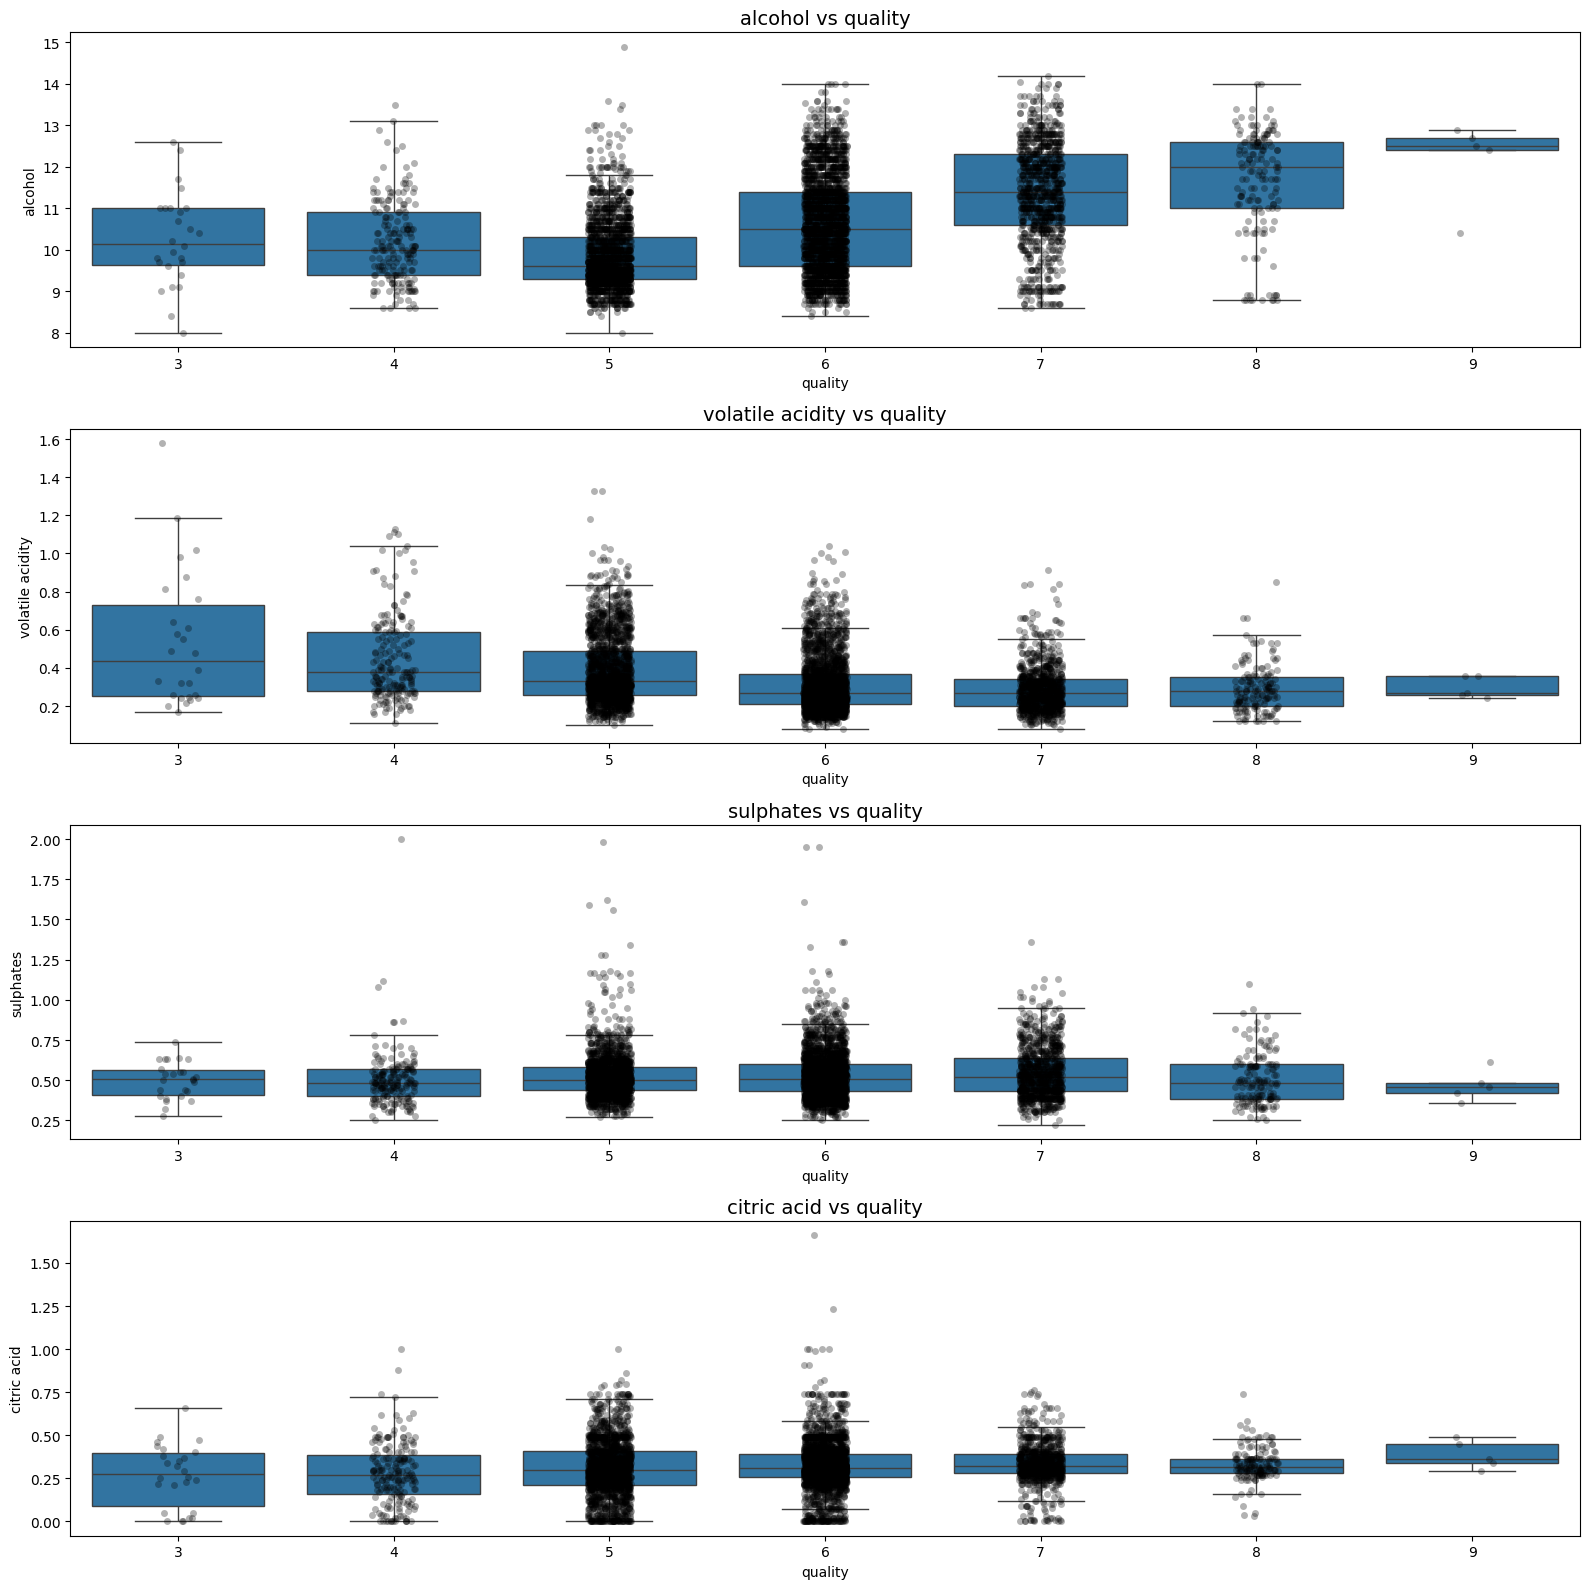

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화할 변수 목록
numeric_columns = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']

plt.figure(figsize=(16, len(numeric_columns) * 4))

for i, col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 1, i+1)
    sns.boxplot(x='quality', y=col, data=train_df, showfliers=False)
    sns.stripplot(x='quality', y=col, data=train_df, color='black', alpha=0.3, jitter=True)
    plt.title(f'{col} vs quality', fontsize=14)

plt.tight_layout()
plt.show()

- 시각화 결과 alcohol, volatile acidity 변수를 범주화하는 것으로 결정.

In [9]:
#와인 종류 인코딩
train_df['type'] = train_df['type'].map({'white': 0, 'red': 1})
test_df['type'] = test_df['type'].map({'white': 0, 'red': 1})

#alcohol: 연속 등분
train_df['alcohol_bin'] = pd.cut(train_df['alcohol'], bins=3, labels=['low', 'medium', 'high'])
test_df['alcohol_bin'] = pd.cut(test_df['alcohol'], bins=3, labels=['low', 'medium', 'high'])

#volatile acidity: 분위수 기준
train_df['volatile_acidity_bin'] = pd.qcut(train_df['volatile acidity'], q=3, labels=['high', 'medium', 'low'])
test_df['volatile_acidity_bin'] = pd.qcut(test_df['volatile acidity'], q=3, labels=['high', 'medium', 'low'])

In [10]:
# 사용할 feature와 target 지정
X = train_df.drop(columns=['quality'])
y = train_df['quality']

# 수치형/범주형 feature 나누기
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

# bin 컬럼 범주형 처
bin_cols = ['alcohol_bin', 'volatile_acidity_bin']
for col in bin_cols:
    X[col] = X[col].astype('category')
    test_df[col] = test_df[col].astype('category')
    categorical_features.append(col)
    if col in numeric_features:
        numeric_features.remove(col)

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


**데이터셋 시각화**

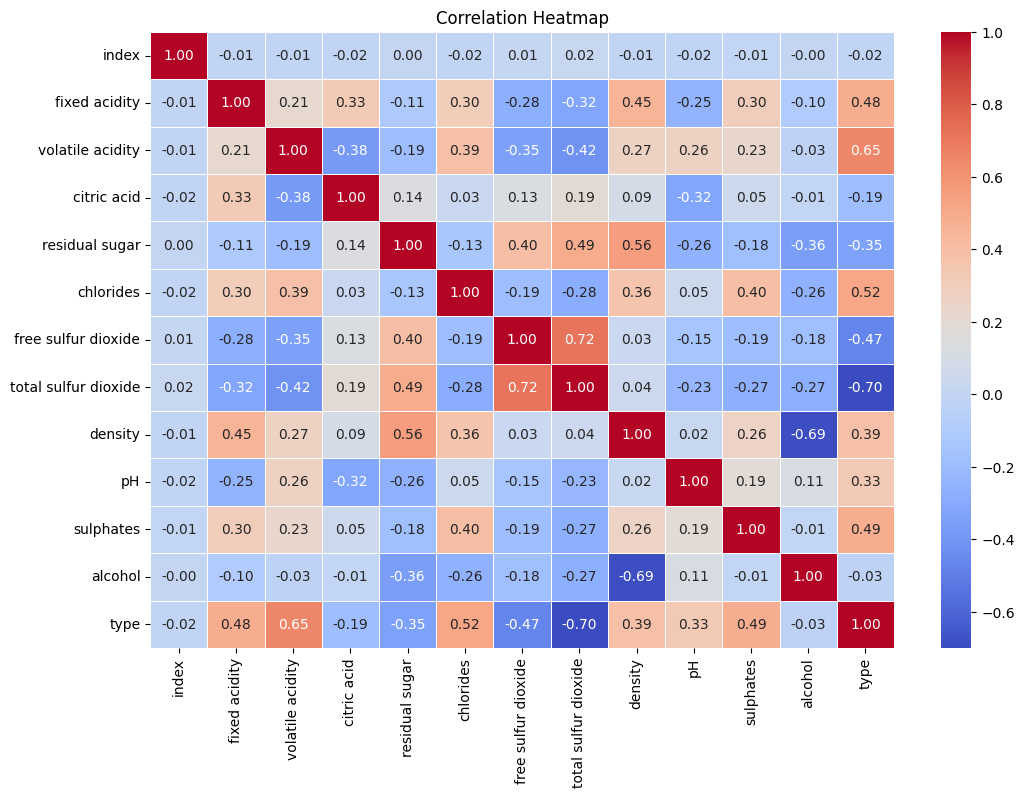

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

*   quality의 분포

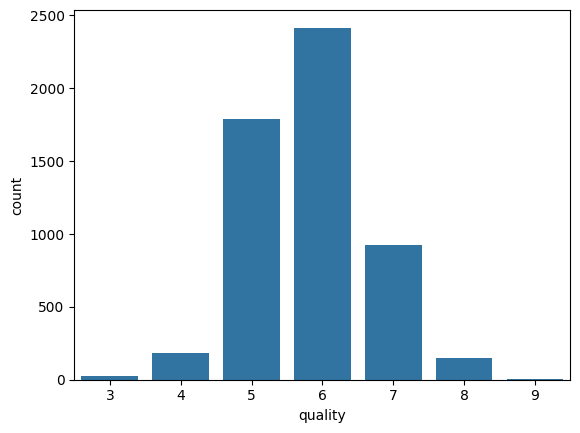

In [ ]:
sns.countplot(x='quality',data=train_df)
plt.show()

와인의 품질 분포는 일반적으로 정규 분포를 따른다.

이는 대부분의 와인이 중간 수준의 품질을 가지고 있음을 의미한다.

와인의 시장 점유율 측면에서도 중간 품질의 와인이 우세하다.

따라서 와인의 품질을 상,중,하로 분류한다면 중간 품질의 와인(quality=6)이 가장 많은 비중을 차지하게 된다.

alcohol_bin의 분포

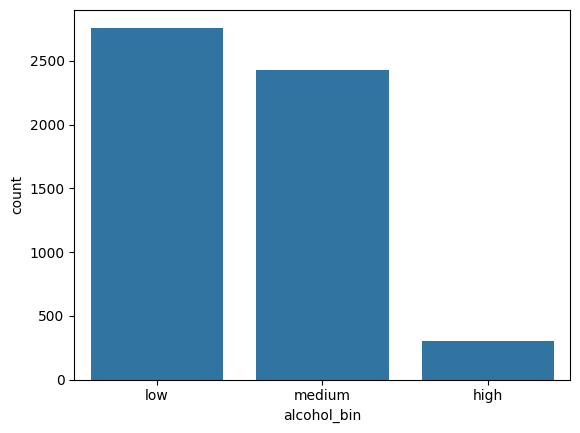

In [ ]:
import seaborn as sns

sns.countplot(x='alcohol_bin',data=train_df)
plt.show()

*   alcohol_bin별 quality

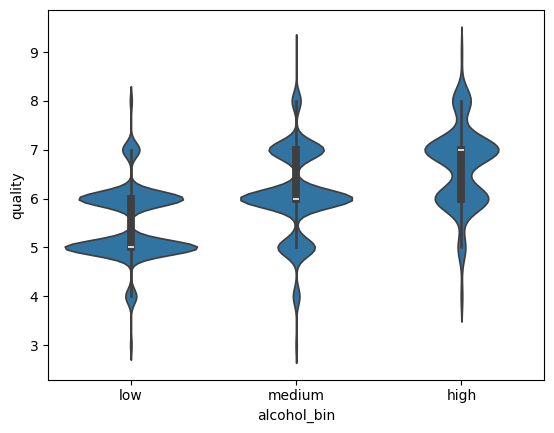

In [ ]:
sns.violinplot(x='alcohol_bin',y='quality',data=train_df)
plt.show()

violinplot을 통해 alcohol_bin별 quality를 자세히 살펴본다.

boxplot만 보면 medium과 high의 분포가 비슷해 보이지만, high가 확연히 중앙값이 더 높고, quality가 높은 쪽에 더 많은 자료가 분포하고 있다.

중앙값(하얀선) 기준으로 보면, alcohol_bin이 low -> medium -> high로 갈수록 quality가 높아진다.

**그러나**, 와인의 도수가 높다고 해서 반드시 품질이 좋은 것은 아니다.

높은 도수는 일반적으로 와인을 더 진하게 만들어주지만, 와인이 덥다거나 뜨겁다는 느낌을 줄 수 있다.

*   volatile_acidity_bin별 quality

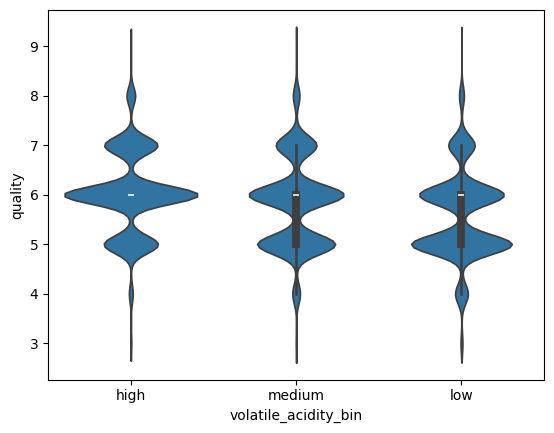

In [ ]:
sns.violinplot(x='volatile_acidity_bin',y='quality',data=train_df)
plt.show()

volatile_acidity_bin별 quality의 중앙값은 모두 비슷하다.

특이점을 찾기 어렵다.

*   fixed acidity(고정 산도)와 volatile acidity(휘발성 산도)의 관계

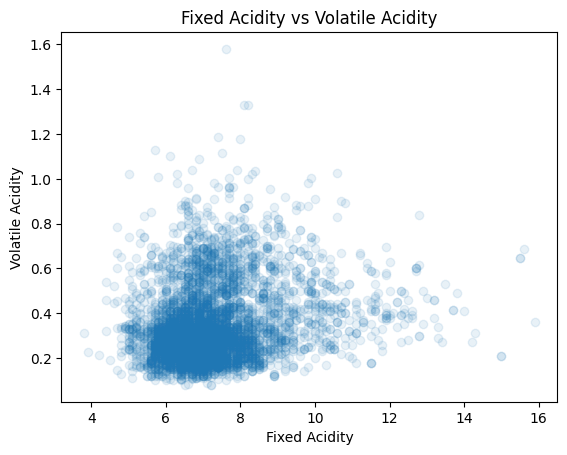

In [ ]:
plt.scatter(x='fixed acidity', y='volatile acidity', data=train_df, alpha=0.1)
plt.xlabel('Fixed Acidity')
plt.ylabel('Volatile Acidity')
plt.title('Fixed Acidity vs Volatile Acidity')
plt.show()

fixed acidity가 높으면 volatile acidity가 높게 나타나는 경향이 있다.

와인의 품질은 fixed acidity와 volatile acidity의 균형에 따라 달라진다.

fixed acidity가 적절하게 유지되면 volatile acidity가 낮아져 와인의 품질이 향상될 수 있다.

# **분류 모델**

# **bagging**

In [ ]:
# train_df를 학습용, 검증용으로 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        DecisionTreeClassifier(min_samples_split=2, max_depth=5),
        n_estimators=100,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['index', 'fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol', 'type']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['alcohol_bin',
                                                   'volatile_acidity_bin',
                                                   'alcohol_bin',
                                                   'volatile_acidity_bin'])])),
                ('classifier',
                 BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                                   n_estimators=100, random_state=42))])

In [ ]:
# 예측
y_pred = pipeline.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.5545


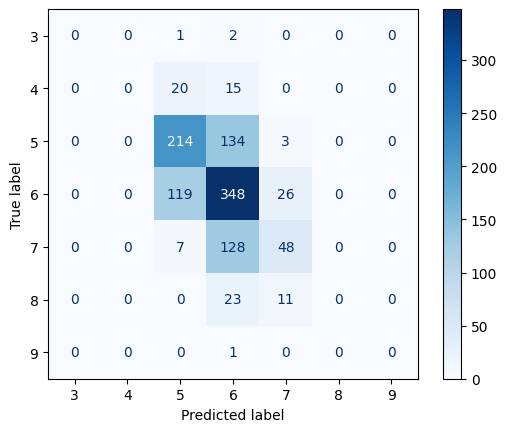

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_val,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=pipeline.classes_)
disp.plot(cmap='Blues')
plt.show()

# **random forest**

> 인용구 추가



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)  # Adjust cv as needed
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['index',
                                                                          'fixed '
                                                                          'acidity',
                                                                          'volatile '
                                                                          'acidity',
                                                                          'citric '
                                                                          'acid',
                                                                          'residual '
                                                                          'sugar',
                                                                          'chlorides',
                                                                          'free '
                                                                          'sulfur '
                                                                          'dioxide',
                                                                          'total '
                                                                          'sulfur '
                                                                          'dioxide',
                                                                          'density',
                                                                          'pH',
                                                                          'sulphates',
                                                                          'alcohol',
                                                                          'type']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['alcohol_bin',
                                                                          'volatile_acidity_bin',
                                                                          'alcohol_bin',
                                                                          'volatile_acidity_bin'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100, 150]})

In [ ]:
# 예측
y_pred = grid_search.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 1.0000


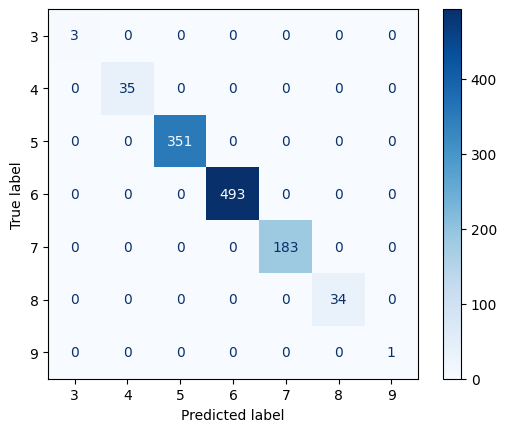

In [ ]:
conf_matrix = confusion_matrix(y_val,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid_search.classes_)
disp.plot(cmap='Blues')
plt.show()

# **boosting**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# 모델 정의
models = {
    'LGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# 학습 데이터와 테스트 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 및 예측
for model_name, model in models.items():
    print(f"\n==== {model_name} ====")
    # 파이프라인: 전처리 + 모델 학습
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])



==== LGBM ====

==== XGBoost ====

==== GradientBoosting ====


In [ ]:
# 모델 학습
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['index', 'fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol', 'type']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['alcohol_bin',
                                                   'volatile_acidity_bin',
                                                   'alcohol_bin',
                                                   'volatile_acidity_bin'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [ ]:
# 예측
y_pred = pipeline.predict(X_val)


acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.5509


In [ ]:
# 성능 평가
print(f"Model: {model_name}")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("-" * 50)

Model: GradientBoosting
Accuracy: 0.5509090909090909
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.20      0.11      0.15        35
           5       0.61      0.55      0.58       351
           6       0.55      0.69      0.61       493
           7       0.50      0.33      0.40       183
           8       0.70      0.21      0.32        34
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1100
   macro avg       0.37      0.27      0.29      1100
weighted avg       0.55      0.55      0.54      1100

--------------------------------------------------


# **스태킹 (Stacking)**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:
# 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# 기본 모델 정의
base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))  # meta 모델 학습을 위해 prob=True
]

In [ ]:
# 메타 모델 정의
meta_model = LogisticRegression(max_iter=1000)

In [ ]:
stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3))
])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# 학습
stacking_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['index', 'fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol', 'type']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['alcohol_bin',
                                                   'volatile_acidity_bin',
                                                   'alcohol_bin',
                                                   'volatile_acidity_bin'])])),
                ('classifier',
                 StackingClassifier(cv=3,
                                    estimators=[('decision_tree',
                                                 DecisionTreeClassifier(random_state=42)),
                                                ('random_forest',
                                                 RandomForestClassifier(random_state=42)),
                                                ('svc',
                                                 SVC(probability=True,
                                                     random_state=42))],
                                    final_estimator=LogisticRegression(max_iter=1000)))])

In [ ]:
# 예측 및 정확도 출력
y_pred = stacking_clf.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print(f"Stacking Model Accuracy: {acc:.4f}")

Stacking Model Accuracy: 0.6464


In [ ]:
# test 데이터에도 동일한 전처리 적용해서 예측
preds = stacking_clf.predict(test_df)

# **결정트리**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [13]:
#quality 범주화 (저/중/고 품질로 분류)
def categorize_quality(q):
    if q <= 5:
        return 'low'
    elif q == 6:
        return 'medium'
    else:
        return 'high'

train_df['quality_category'] = train_df['quality'].apply(categorize_quality)

In [14]:
# 알코올 도수에 따라 low/mid/ : 비교적 고르게 분포하여 간단히 범주화
def categorize_alcohol(a):
    if a < 10:
        return 'low'
    elif a < 11.5:
        return 'mid'
    else:
        return 'high'

train_df['alcohol_level'] = train_df['alcohol'].apply(categorize_alcohol)

In [15]:
# 알코올 도수에 따라 low/mid/ : 비교적 고르게 분포하여 간단히 범주화 (test도 동일하게)
def categorize_alcohol(a):
    if a < 10:
        return 'low'
    elif a < 11.5:
        return 'mid'
    else:
        return 'high'

test_df['alcohol_level'] = test_df['alcohol'].apply(categorize_alcohol)

In [16]:
# 당 수준
train_df['sugar_level'] = pd.cut(train_df['residual sugar'],
                                 bins=[0, 2, 10, 70],
                                 labels=['low', 'mid', 'high'])

# 휘발성 산도 수준
train_df['acid_level'] = pd.cut(train_df['volatile acidity'],
                                bins=[0, 0.3, 0.6, 2],
                                labels=['low', 'mid', 'high'])

# 당 수준
test_df['sugar_level'] = pd.cut(test_df['residual sugar'],
                                 bins=[0, 2, 10, 70],
                                 labels=['low', 'mid', 'high'])

# 휘발성 산도 수준
test_df['acid_level'] = pd.cut(test_df['volatile acidity'],
                                bins=[0, 0.3, 0.6, 2],
                                labels=['low', 'mid', 'high'])

In [17]:
# 산도 (3.0 미만은 강한 산도, 3.0-3.4는 일반적, 3.4이상은 부드러운 산도): 대신 변화 폭은 작아서 범주화가 필수적이진 않을 것 같음.
train_df['pH_level'] = pd.cut(train_df['pH'],
                              bins=[2, 3.0, 3.4, 4.5],
                              labels=['low', 'mid', 'high'])

test_df['pH_level'] = pd.cut(test_df['pH'],
                              bins=[2, 3.0, 3.4, 4.5],
                              labels=['low', 'mid', 'high'])

In [18]:
# 사용할 feature와 target 지정
X = train_df.drop(columns=['quality'])
y = train_df['quality']

# 수치형/범주형 feature 나누기
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

# bin 컬럼 범주형 처
bin_cols = ['alcohol_bin', 'volatile_acidity_bin']
for col in bin_cols:
    X[col] = X[col].astype('category')
    test_df[col] = test_df[col].astype('category')
    categorical_features.append(col)
    if col in numeric_features:
        numeric_features.remove(col)

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(
            SimpleImputer(strategy='mean'),   # 수치형 NaN → 평균값으로 대체
            StandardScaler()
        ), numeric_features),

        ('cat', make_pipeline(
            SimpleImputer(strategy='most_frequent'),  # 범주형 NaN → 최빈값으로 대체
            OneHotEncoder(handle_unknown='ignore')
        ), categorical_features)
    ]
)

# 모델 구성: 전처리 파이프라인 + 로지스틱 회귀
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 학습
logreg_pipe.fit(X_train, y_train)

# 예측 및 평가
y_pred = logreg_pipe.predict(X_val)
print("정확도:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

정확도: 0.9336363636363636
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.40      0.06      0.10        35
           5       0.91      0.99      0.95       351
           6       1.00      1.00      1.00       493
           7       0.84      1.00      0.91       183
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00         1

    accuracy                           0.93      1100
   macro avg       0.45      0.44      0.42      1100
weighted avg       0.89      0.93      0.91      1100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# 결정나무 모델 구성
tree_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, random_state=42))
])

# 학습
tree_pipe.fit(X_train, y_train)

# 예측 및 평가
y_tree_pred = tree_pipe.predict(X_val)
print("정확도 (결정나무):", accuracy_score(y_val, y_tree_pred))
print(classification_report(y_val, y_tree_pred))

정확도 (결정나무): 0.860909090909091
              precision    recall  f1-score   support

           3       0.03      0.33      0.05         3
           4       0.00      0.00      0.00        35
           5       0.92      0.93      0.93       351
           6       1.00      1.00      1.00       493
           7       0.88      0.63      0.73       183
           8       0.17      0.26      0.21        34
           9       0.03      1.00      0.06         1

    accuracy                           0.86      1100
   macro avg       0.43      0.59      0.43      1100
weighted avg       0.89      0.86      0.87      1100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5]
}

grid = GridSearchCV(tree_pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("최적 파라미터:", grid.best_params_)
print("검증 정확도:", grid.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


최적 파라미터: {'classifier__max_depth': 6, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
검증 정확도: 0.7659734719205709


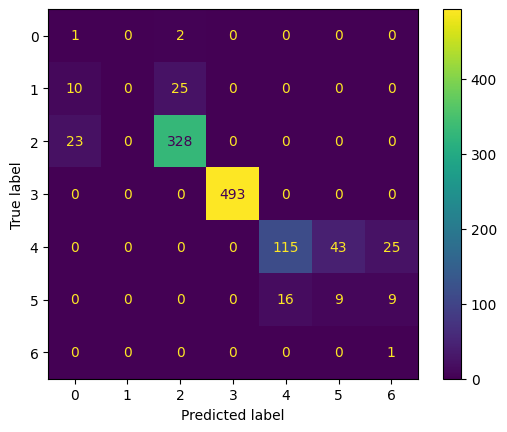

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_tree_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

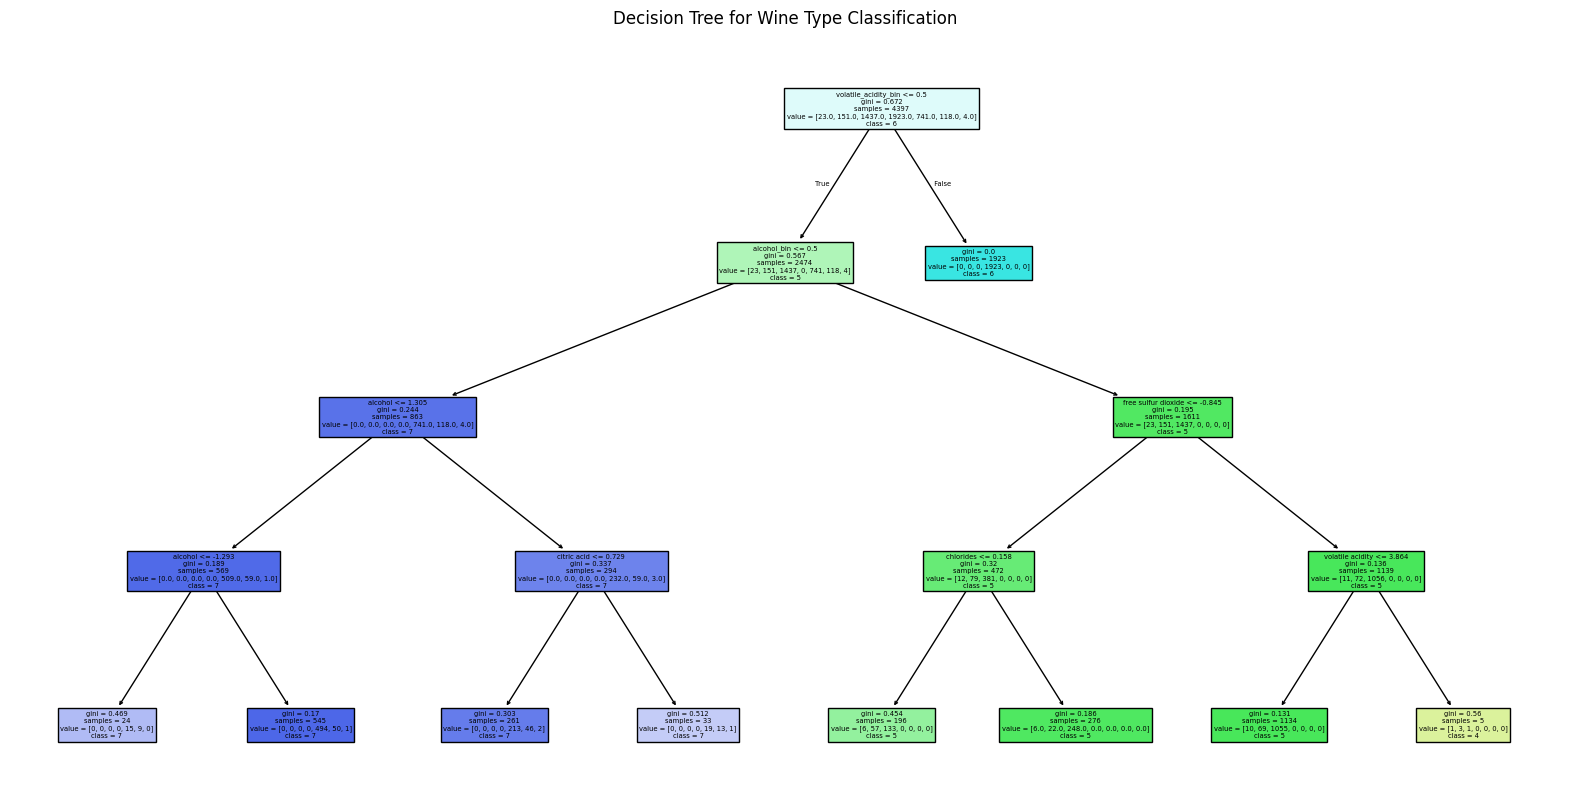

In [24]:
# 전처리된 훈련 데이터 얻기
X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = preprocessor.transformers_[0][2] + \
    preprocessor.transformers_[1][2]



# 결정나무 모델만 따로 학습 (전처리 제외)
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train_transformed, y_train)

# 시각화
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=clf.classes_.astype(str))
plt.title("Decision Tree for Wine Type Classification")
plt.show()